In [1]:
# Here we just tune the EI-ratio to study its effect on 
# fMRI FC, correlation between synaptic time series and 
# synaptic input amplitude

import sys 
import numpy as np
from numpy.random import seed
from numpy.random import randn
from scipy.signal import decimate
from scipy.io import savemat, loadmat

#################################################
##### PARAMETERS ################################
#################################################
#EI_ratio = float(sys.argv[1])
#rng_seed = int(sys.argv[2])
EI_ratio = 2.1
N = 100
rng_seed = 1
seed(rng_seed) # Important: vary RNG seed in re-simulations
FIC_ts = 40 * 60 * 1000 # number of time steps for FIC tuning
ts = FIC_ts + 1 * 60 * 1000 # (ms) total simulation time

inp_var  = np.linspace(0.01,4.0,N)
inp_off  = 0.382

# Excitation-Inhibition ratio is the ratio of long-range excitation
# (LRE) to feedforward inhibition (FFI)
# compute LRE and FFI based on solving a system of two equations
# (1) LRE / FFI = EI_ratio
# (2) LRE + FFI = 1
# That is, the coefficients LRE and FFI should always sum to 1, in
# order to not change the sum total of global coupling, because this
# would in turn affect currents. 
FFI = 1 / (EI_ratio + 1)
LRE = EI_ratio * FFI


# Generate sine wave input
sample_rate = 1000
start_time = 0
end_time = ts/sample_rate
frequency = 10
time = np.arange(start_time, end_time, 1/sample_rate)
sinewave = np.sin(2 * np.pi * frequency * time)

# Hemodynamic response function
#hrf = loadmat('HRF_200Hz.mat')
#hrf = hrf['HRF_200Hz'].T[:,0]


#################################################
##### Helper functions ##########################
#################################################

# Eq. 3 Deco2014
def rww_I_E(S_E, S_I, J_i, inj_inp, LRE):
    W_E = 1.0
    I_0 = 0.382 # (nA)
    w_p = 1.4
    J_NMDA = 0.15 # (nA)    
    E_loc = w_p * J_NMDA * S_E
    E_glob = J_NMDA * LRE * inj_inp
    I_loc = J_i * S_I
    I = W_E * I_0 + E_loc + E_glob - I_loc
    #I = W_E * I_0 + w_p * J_NMDA * S_E + J_NMDA * LRE * np.dot(SC, S_E) - J_i * S_I
    return I

# Eq. 4 Deco2014
def rww_I_I(S_E, S_I, inj_inp, FFI):
    W_I = 0.7
    I_0 = 0.382 # (nA)
    J_NMDA = 0.15 # (nA)
    I = W_I * I_0 + J_NMDA * S_E - S_I + J_NMDA * FFI * inj_inp
    return I

# Eq. 5 Deco2014
def rww_r_E(I):
    a = 310.0 # (Hz/nA)
    b = 125.0 # (Hz)
    d = 0.16 # (s)    
    tmp = a * I - b
    phi = tmp / (1.0 - np.exp(-d * tmp))
    return phi

# Eq. 6 Deco2014
def rww_r_I(I):
    a = 615.0 # (Hz/nA)
    b = 177.0 # (Hz)
    d = 0.087 # (s)    
    tmp = a * I - b
    phi = tmp / (1.0 - np.exp(-d * tmp))
    return phi

# Eq. 7 Deco2014
def rww_S_E(S_E, r_E):
    dt = 1.0
    tau_E = 100.0 # (ms)
    gamma_E = 0.641/1000.0 # /1000: all units in ms not s
    sigma = 0.01
    dS = -S_E / tau_E + (1.0 - S_E) * gamma_E * r_E    
    S = S_E + dt * dS
    S[S<0] = 0   
    S[S>1] = 1
    return S

# Eq. 8 Deco2014
def rww_S_I(S_I, r_I):
    dt = 1.0
    tau_I = 10.0 # (ms)
    gamma_I = 1.0/1000.0 # /1000: all units in ms not s
    sigma = 0.01
    dS = -S_I / tau_I + gamma_I * r_I   
    S = S_I + dt * dS
    S[S<0] = 0   
    S[S>1] = 1
    return S

# Inhibitory synaptic plasticity as in Vogels et al. Science
def ISP(J_i, pre, post): 
    eta = 0.0001 # smaller eta than in Vogels article
    r0  = 4.0 # target firing rate    
    J_i = J_i + eta * (pre * post - r0 * pre)
    J_i[J_i<0] = 0
    return J_i

# convolve synaptic gating with HRF to simulate fMRI
def compute_BOLD(y, HRF):
    y = decimate(y, 5) # downsample to 200 Hz
    y = np.convolve(y, HRF, mode='valid'); # convolve with HRF
    y = y[::200] # downsample to 1 Hz
    return y




#################################################
##### Initialize state variables ################
#################################################


# RWW variables
S_E = np.zeros((N))
S_I = np.zeros((N))
J_i = 1.0 * np.ones((N))


# RWW output variables    
J_iout = np.zeros((ts,N))
S_Eout = np.zeros((ts,N))
#S_Iout = np.zeros((ts,N))
r_Eout = np.zeros((ts,N))
r_Iout = np.zeros((ts,N))
I_Eout = np.zeros((ts,N))


############################################
##### Integrate brain model ################
############################################
for ii in range(ts):   
    inp = inp_off + inp_var * sinewave[ii]
    # integrate RWW (i.e. compute Eqs. 3 to 8 from Deco2014)
    I_E = rww_I_E(S_E, S_I, J_i, inp, LRE)
    I_I = rww_I_I(S_E, S_I, inp, FFI)
    r_E, r_I = rww_r_E(I_E), rww_r_I(I_I)
    S_E, S_I = rww_S_E(S_E, r_E), rww_S_I(S_I, r_I)

    # store results
    S_Eout[ii,:], r_Eout[ii,:], r_Iout[ii,:], I_Eout[ii,:] = S_E, r_E, r_I, I_E 


    # apply inhibitory synaptic plasticity
    if ii < FIC_ts and np.mod(ii, 500) == 0 and ii > 25000:
        pre  = np.mean(r_Iout[ii-20000:ii,:], axis=0)
        post = np.mean(r_Eout[ii-20000:ii,:], axis=0)
        J_i = ISP(J_i, pre, post)
        print(ii/ts*100, "%", end = "\r")
    J_iout[ii,:] = J_i;

# Make sure that FIC tuning converged
#if np.sum(np.abs(np.mean(r_Eout[FIC_ts:,:], axis=0) - 4.0) > 0.4) > 0:
#    print('Error: FIC tuning did not sufficiently converge.')
#    sys.exit("Exit with error: FIC did not converge") 


############################################
##### Compute result statistics ############
############################################

# compute average synaptic input current amplitudes
ampsyn = np.mean(I_Eout[FIC_ts:,:],axis=0)  
# compute variance of synaptic input current amplitudes
varsyn = np.var(I_Eout[FIC_ts:,:],axis=0) 
# compute max firing rate E
maxFR_E = np.max(r_Eout[FIC_ts:, :],axis=0)
# compute max firing rate I
maxFR_I = np.max(r_Iout[FIC_ts:, :],axis=0)
# compute mean firing rate E
meanFR_E = np.mean(r_Eout[FIC_ts:, :],axis=0)
# compute mean firing rate I
meanFR_I = np.mean(r_Iout[FIC_ts:, :])


res = {'EI_ratio': EI_ratio, 'LRE': LRE, 'FFI': FFI, 
      'ampsyn': ampsyn, 'varsyn': varsyn, 
      'maxFR_E': maxFR_E,
      'maxFR_I': maxFR_I,
      'J_i':J_i,
      'meanFR_E': meanFR_E,
      'meanFR_I': meanFR_I}

filename = "res_msBNM_EI_VARvsMEAN_FIC.mat"
savemat(filename, res)

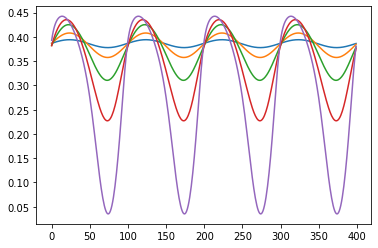

In [25]:
import matplotlib.pyplot as plt
plt.plot(I_Eout[-400:,[3,10,25,50,99]])

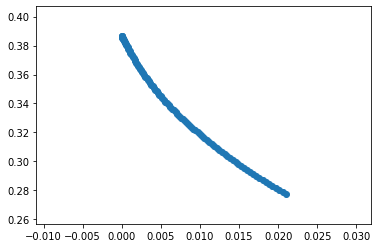

In [4]:
plt.scatter(varsyn, ampsyn)

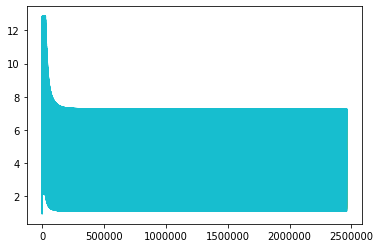

In [5]:
plt.plot(r_Eout)

In [15]:
inp_var  = np.linspace(0.01,0.1,N)
sinewave[20]*inp_var

array([0.00429553, 0.00468603, 0.00507653, 0.00546704, 0.00585754,
       0.00624804, 0.00663854, 0.00702905, 0.00741955, 0.00781005,
       0.00820055, 0.00859106, 0.00898156, 0.00937206, 0.00976256,
       0.01015307, 0.01054357, 0.01093407, 0.01132457, 0.01171508,
       0.01210558, 0.01249608, 0.01288658, 0.01327709, 0.01366759,
       0.01405809, 0.0144486 , 0.0148391 , 0.0152296 , 0.0156201 ,
       0.01601061, 0.01640111, 0.01679161, 0.01718211, 0.01757262,
       0.01796312, 0.01835362, 0.01874412, 0.01913463, 0.01952513,
       0.01991563, 0.02030613, 0.02069664, 0.02108714, 0.02147764,
       0.02186814, 0.02225865, 0.02264915, 0.02303965, 0.02343015,
       0.02382066, 0.02421116, 0.02460166, 0.02499216, 0.02538267,
       0.02577317, 0.02616367, 0.02655417, 0.02694468, 0.02733518,
       0.02772568, 0.02811618, 0.02850669, 0.02889719, 0.02928769,
       0.0296782 , 0.0300687 , 0.0304592 , 0.0308497 , 0.03124021,
       0.03163071, 0.03202121, 0.03241171, 0.03280222, 0.03319

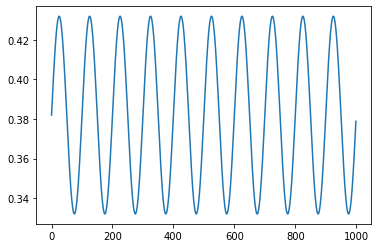

In [9]:
plt.plot(sinewave[FIC_ts:FIC_ts+1000])

In [14]:
np.linspace(0.01,0.1,10)

array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ])

In [13]:
ampsyn, varsyn, maxFR_E, maxFR_I

(0.3833844365595857,
 0.0002927550032237812,
 20.41679582225335,
 31.626240933812444)

0.005000000000000001

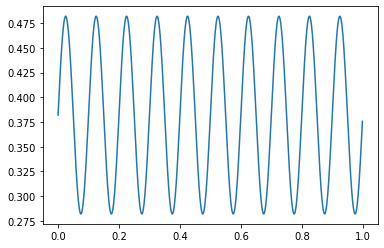

In [20]:
import numpy as np
import matplotlib.pyplot as plt

FIC_ts = 40 * 60 * 1000 # number of time steps for FIC tuning
ts = FIC_ts + 10 * 60 * 1000 # (ms) total simulation time

inp_var  = 0.1
inp_off  = 0.382
sample_rate = 1000
start_time = 0
end_time = 1
frequency = 10
time = np.arange(start_time, end_time, 1/sample_rate)
sinewave = inp_off + inp_var * np.sin(2 * np.pi * frequency * time)
plt.plot(time,sinewave)
np.var(sinewave)

In [7]:
sinewave.shape

(1000,)

In [6]:
res = {
        'E_global':E_global, 
        'E_local':E_local, 
        'I_local':I_local,
        'S_Eout':S_Eout, 
        'S_Iout':S_Iout, 
        'r_Eout':r_Eout, 
        'r_Iout':r_Iout,
        'LSI_node1':LSI_node1, 
        'LSI_node2':LSI_node2,
        'BOLD_node1':BOLD_node1,
        'BOLD_node2':BOLD_node2
      }

filename = "out_low.mat"
savemat(filename, res)

In [3]:
ccsyn,ccfMRI

(-0.7136112877911936, -0.8091030064027737)

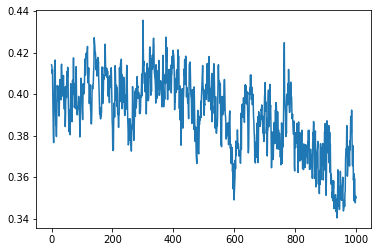

In [2]:
import matplotlib.pyplot as plt
plt.plot(LSI_node1[FIC_ts:FIC_ts+1000])